In [1]:
%matplotlib inline
# Use autoreload so that updating hmm_class.py is immediately reflected in future cell executions in the notebook.
# For details on the autoreload extension, see
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image
from sklearn.metrics import confusion_matrix
#from hmm_class import HMM
from hmm_elan import HMM

# Hidden Markov Models (HMMs)

Up to this point all the data we have worked with has been treated as i.i.d. - i.e. all the different observations were viewed as independent from each other - even when this clearly is not the case, such as with the signature data where each coordinate depends on past coordinates. 

One of the most fundamental tasks of machine learning is to model dependencies between variables. HMMs have been designed to do just this. These days we know that HMMs are just a particularly simple example of a more general class of models, namely Probabilistic Graphical Models. 

HMMs model dynamic processes, or processes that can be thought of as being dynamic. In practice this means that we observe a dynamic process that provides us with observations (or samples) at successive time instances. Signatures are good examples: At fixed intervals, the tablet registers the $x$ and $y$ coordinates of the pen (among other things). Plotted in sequence, we display the signature. 

For the HMM model, the idea is that at each time instant generating an observation, the system is in one of a finite set of $k$ (emitting) states. This means that we are dealing with discrete states. Although we do not investigate it here, it is also possible to assume continuous states, a situation modeled by the Kalman filter. In either case, the state sequence, as one proceeds from one time instance to the next, is hidden (unknown), hence the *Hidden* in Hidden Markov models.

Each emitting state is associated with a probability density function (pdf). We will use the Gaussian distribution for simplicity; a more general choice would be Gaussian Mixture Models (GMMs). The model then specifies that the observation generated by an emitting state is obtained by sampling from the state's pdf.  Thus the data we observe in practice is viewed as being generated by sampling the pdf's of the emitting states, while the underlying state changes over time.

It is convenient to work with additional, non-emitting states, as well.  For this course (and in your code), the initial and final states, numbered -1 and  $k$, are non-emitting. 

The parameters associated with an HMM, and which typically need to be learned from training data, are

* The transition probabilities $A_{ij}$, where $A_{ij}$ is the probability that the system will next enter state $j$, given that it is currently in state $i$. This is what makes it a *Markov* model, since the next state is only determined by the previous state, and not earlier ones. In the context of PGMs, it is conceptually not hard to generalize this to higher-order models, but we will only concern ourselves with first order models. Also note that it is possible to remain in the same state, i.e. $A_{ii}$ is not necessarily zero. Note that in principle there is no limitation on how to proceed between states. The implementation you will develop in this assignment allows only a left-to-right model, however. That means that from state $i$ one can only proceed to state $j$ if $j\geq i$. Finally note that the $A_{ij}$ are probabilities and therefore normalized so that $\sum_j A_{ij} = 1$.  An additional row and column are added to the bottom and right of $A$ in the code, to model transitions from the initial non-emitting state and into the final non-emitting state respectively.
* As mentioned above, each emitting state is associated with a pdf, in our case a Gaussian. The pdf's also need to be estimated during the training stage. This phase is sensitive to strange situations where not enough data is associated with a specific hidden state, leading to degenerate Gaussians and similar problems.  **The code may thus discard unused emitting states during the training process**.
* HMMs are *generative* models, i.e. it is possible to draw samples from a trained HMM. For example, for a signature verification system a model might be developed from the available signatures of a signatory.  Then it is possible to generate sample "signatures" which resemble this training data from the perspective of the model.

### Training

Usually we'll be given several training sequences produced by the same entity, e.g. several examples of the signatures of a single signatory will be available. The next step is to choose the number of emitting states $k$. This usually requires experimentation using a validation set. Assume for now that it is known.

The training again proceeds using an EM algorithm called **Viterbi re-estimation**. The basic idea is simple:
* First estimate or guess the transition probabilities as well as the pdf's associated with each state.
* Use the present estimate of the HMM parameters to fit an observation sequence to the model. This is done by **the Viterbi algorithm that finds the optimal state sequence for the observation sequence**. Keep a record of the obervations that are assigned to each state. Also keep a count of the number of state transitions. Do this for all the training sequences. After all the training sequences have been processed, each state should have a number of observations assigned to it. (If there is an empty state, it should be deleted). The observations associated with a state are used to estimate the pdf of that state. Since counts are also calculated for the various state transitions, they only need to be normalized in order to find new state transition probabilities.
* With a new estimate of the HMM available, the process is repeated until convergence.

(Note that unlike the EM algorithm for fitting a GMM, which used responsibilities to allocate data points to multiple clusters, **observations are assigned fully to one of the emitting states**.  A similar partial (or soft) allocation strategy exists that can be used for HMM training, called the Baum-Welch algorithm.)

### The Viterbi and forward algorithms

Given an observation sequence, the Viterbi algorithm finds the optimal state transition sequence that explains the observations. This really lies at the heart of the HMM. We explained above how crucial the Viterbi algorithm is during training. It lies also at the heart of inference.

Assume that we have built probabilistic models of a number of signatories. If your client is a major bank, this can run into the millions. For signature verification, you are presented with a signature sequence as well as a claim about the identity of the signatory. The task of the system is to verify this claim. That means that the signature, i.e. the observation sequence, needs to be fitted to the claimed model. If it is a good fit, the signature is accepted. Otherwise it is rejected. It is not so straightforward to decide what is a good fit and we will not pursue that question here. Here our aim is just to quantify how well the signature corresponds to the model. The algorithm we use for this is **the forward algorithm which returns the likelihood of the observed sequence under the model**. Since a likelihood is returned (and not a probability), it is not so easy to decide what is an acceptable fit to accept the sequence, as alluded to above.  (Further, since the likelihood depends on the length of the sequence, it is common to normalize the (log-)likelihood with respect to the number of observations.)

### Software

`scikit-learn` does not have an HMM implementation; instead in this assignment you will develop an HMM library from a skeleton provided to you.  To keep things manageable, we will only consider left-to-right topologies with Gaussian emission densities.  (You may also be interested in investigating or experimenting with the HMMlearn python library.)

The skeleton code provided in `hmm.py` you are provided with has various functions for you to complete - these are indicated by the `pass` keyword.  By executing the class (with `python3 hmm.py` on the command line), various doctests are executed to indicate whether your code functions as expected.  These doctests are essentially ipython sessions showing code with expected corresponding output.

### A simple example

As a simple example to see what is happening, let us consider a simple example, based on the example in the code comments. Here we provide the system with 2 sequences of 1-dimensional observations for training, the first with 11 observations, and the second with 7.

By observation of the signals, it should not be hard to see that the data is roughly clustered around 3 values, namely 1.0, 0.1 and 3.5. We therefore specify 3 states.  Fitting the model yields transition probabilities between the states, as well as the parameters (means and covariances) of the Gaussian densities associated with each state.

We print the trained HMM parameters from the solution code below - note that this corresponds to a portion of the doctest specifed for the HMM class. **Verify that the output makes sense to you.  Ensure you understand what the last row and column in the transition table are for.**

In [3]:
# SAMPLE CODE: EXECUTION WILL INITIALLY FAIL

# Define signals
signal1 = np.array([[ 1. ,  1.1,  0.9, 1.0, 0.0,  0.2,  0.1,  0.3,  3.4,  3.6,  3.5]])
signal2 = np.array([[0.8, 1.2, 0.4, 0.2, 0.15, 2.8, 3.6]])

# Collect training data together
toy_data = np.hstack([signal1, signal2])
toy_lengths = [11, 7]

# Create and fit HMM model to data
toy_hmm = HMM()
toy_hmm.fit(toy_data, toy_lengths, 3)

toy_means = [d.get_mean() for d in toy_hmm.dists]
toy_covs = [d.get_cov() for d in toy_hmm.dists]
print ('Transition probabilities: ')
print (toy_hmm.trans)
print ('Means: ')
print (toy_means)
print ('Covariances: ')
print (toy_covs)

Transition probabilities: 
[[0.66666667 0.33333333 0.         0.        ]
 [0.         0.71428571 0.28571429 0.        ]
 [0.         0.         0.6        0.4       ]
 [1.         0.         0.         0.        ]]
Means: 
[array([1.]), array([0.19285714]), array([3.38])]
Covariances: 
[array([[0.02]]), array([[0.01702381]]), array([[0.112]])]


### Fitting a new signal to the model

Once one has a model (or multiple models), one may obtain a new observation.  An important question is then associating different parts of the signals with the underlying states.  This is achieved by the Viterbi algorithm.  To illustrate this, we continue with two signals for our toy example:

In [4]:
signal3 = np.array([[ 0.9515792,   0.9832767,   1.04633007,  1.01464327,  0.98207072,  1.01116689,
  0.31622856,  0.20819263,  3.57707616]])
seq3, ll3 = toy_hmm.viterbi(signal3)
print(seq3)
print(ll3)

signal4 = np.array([[ 1,   0.6,   0.5 , 3.57707616]]) 
seq4, ll4 = toy_hmm.viterbi(signal4)
print(seq4)
print(ll4)

# Expected output:
#[0 0 0 0 0 0 1 1 2]
#2.23881485357
#[0 0 1 2]
#-7.24978056432

[0 0 0 0 0 0 1 1 2]
2.2388148535736567
[0 0 1 2]
-7.249780564316458


Note that the code above also gives the most likely sequence of states for the given model, not necessarily the true underlying state sequence.  **It is instructive to work through the steps of last example with a calculator or in the Python interpreter, to ensure you do not make common errors which would lead to returning the erroneous sequence [0 1 1 2].**

# Preparing the data.

In this assignment, we will apply HMMs to the signature data that we have used in earlier assignments - again using only the $x$- and $y$-components. We read only 3 of the 15 signatures of a signatory in with `utils.read_signatures` and use them for training. Note how the training signatures are first normalized, and then presented to the system. Note that later you will test a signature classification system using the other 12 signatures for each signatory.

In [5]:
# Some utility functions:

def read_signatures(file):
    '''
    Read all the signatures in a given directory.
    
    Parameters:
    -----------
    file: string
        The name of the directory.
        
    Return:
    -------
    sign: (n,) list
        A list with all the signatures in the directory.
    
    Example
    -------
    >>>from utils import read_signatures
    >>>sign = read_signatures('./data/signatures/sign1/*.txt')       
    >>>print len(sign)
       15
    >>>print sign[0].shape
       (5, 306)
    '''
    import glob
    list_of_files = glob.glob(file) 
    sign = []
    for file_name in list_of_files:
        sign.append(np.loadtxt(file_name,  comments = '%').T)
    return sign

def sign_norm(sign):
    '''   
    Normalize a signature with respect to position, scale and rotation. 
    The aspect ratio is kept intact. Note that only the x,y coordinates are
    used.
    
    Parameters
    -----------
    sign: (2,n) ndarray
        The signature, consisting of n samples of x,y coordinates.
    
    Return
    ------
    
    rot_sign: (2,n) ndarray
        The normalized signature.
    '''
    #sign = sign
    d,n = sign.shape
    sign = sign - np.mean(sign,axis=1)[:,np.newaxis]
    #sign = (sign - mean)
    u, s, vh = np.linalg.svd(sign,full_matrices=False)
    # Try and establish the correct sign of the singular vectors.
    if u[0,0]<0. :
        vh[0,:] = -vh[0,:]
    if u[1,1]<0. :
        vh[1,:] = -vh[1,:]
    sign_norm = np.sqrt(n)*np.diag(s).dot(vh)/s[0]
    return sign_norm

(2, 1628)
[597, 509, 522]


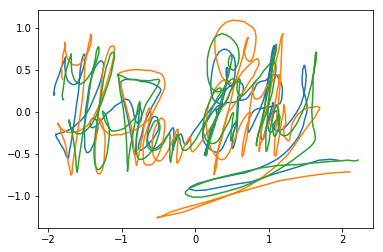

In [6]:
sign = read_signatures('../resources/data/signatures/sign2/*.txt')
n_signs = len(sign)-12
data = sign_norm(sign[0][:2, :])
length = [sign[0].shape[1]]
plt.figure("Signatures: signatory 2")
plt.plot(data[0,:],data[1,:])
for i in range(n_signs-1):
    signi = sign_norm(sign[i+1][:2, :])
    data = np.hstack((data,signi))
    length.append(sign[i+1].shape[1])
    plt.plot(signi[0,:],signi[1,:])
print (data.shape)
print (length)

### Training

**Use the approach above to read in training signatures for each signatory, and train an HMM for each signatory using 5 states and diagonal covariance matrices (we will use most of these models later).  In order to do this, you will need to get much of the functionality of the library working, in particular the Viterbi algorithm and the EM parameter estimation algorithm.**

*Some guidelines on implementation order*:

0. Carefully read the docstrings and review the doctests in the included skeleton file to develop an understanding of the structure of the class.
1. You are required to implement the whole or part of 7 functions.
2. Four of them can be tested by creating an HMM with specified transition matrix and emission densities using the load function: sample, \_forward, \_score, and \_viterbi.
3. The most crucial is \_viterbi, since this is needed by \_calcstates.
4. \_updatecovs is used along with \_calcstates to implement \_em.

Note that running this after implementation is quite a big computation, so can take quite a while.  Our implementation takes around 15 seconds on a Dell Latitute E6520.



In [7]:
def get_signer_data(signer_num, num_features=2, num_test=12):
    sign = read_signatures('../resources/data/signatures/sign'+str(signer_num)+'/*.txt')
    n_signs = len(sign)-num_test
    data = sign_norm(sign[0][:num_features, :])
    length = [sign[0].shape[1]]
    for i in range(n_signs-1):
        signi = sign_norm(sign[i+1][:num_features, :])
        data = np.hstack((data,signi))
        length.append(sign[i+1].shape[1])
    return data, length

n_states = 10
sign_models = []
for signer in range(5):
    sign_hmm = HMM()
    data, length = get_signer_data(signer+1)
    sign_hmm.fit(data, length, n_states)
    sign_models.append(sign_hmm)

### Sampling from an HMM

Since an HMM is a generative model, one is able to sample from the model to generate data from the distribution represented by the model.  This process interleaves sampling state transitions and observations from the corresponding state's emission density until a transition to the final non-emitting state is reached.

**Complete the implementation of the sample function in the skeleton code provided in this assignment, and use it to sample two signals from the model for signatory 2.  Use the code below to plot the sampled signals in separate images, colouring each point based on its associated state.  Ensure you understand the output plots, and can explain how they differ from the signatures the model was trained with.**

(391, 2)
(470, 2)


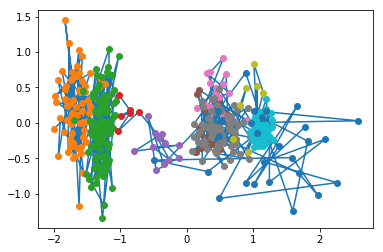

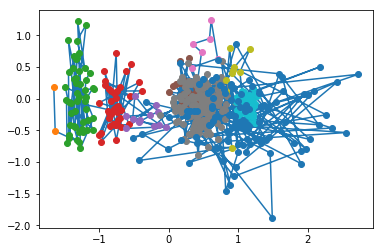

In [8]:
col_list = ['g', 'r', 'c', 'm', 'y', 'k', 'b']
plt.figure("First sampled signal")
samples, states = sign_models[1].sample()
print(samples.shape)
plt.plot(samples[:,0], samples[:,1])
for c in range(sign_hmm._n_states()):
    plt.plot(samples[states==c,0],samples[states==c,1],'o')
plt.figure("Second sampled signal")
samples, states = sign_models[1].sample()
print(samples.shape)
plt.plot(samples[:,0], samples[:,1])
for c in range(sign_hmm._n_states()):
    plt.plot(samples[states==c,0],samples[states==c,1],'o')

### Visualise the different states - Viterbi on signatures

It is instructive to visualise the assignment of the observations to the different classes for signatures.

**Take 2 arbitrary training signatures from different signatories, allocate the points to states using the Viterbi algorithm, and display the points in the signatures on separate plots, colouring each point based on its associated state. The resulting images should look something like the example below (which was for signatory 2 using 10 hidden states):**

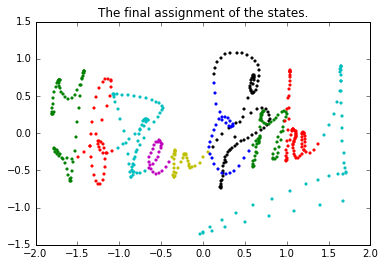

In [9]:
display(Image(filename='../resources/images/hmm1.png'))

(2, 69)
(2, 43)
(2, 63)
(2, 59)
(2, 5)
(2, 100)
(2, 39)
(2, 54)
(2, 58)
(2, 41)


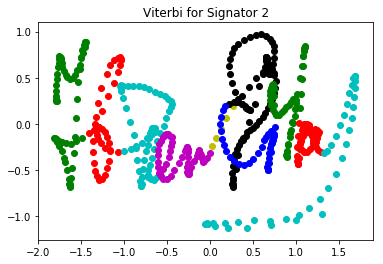

In [10]:
# TODO: INSERT CODE FOR ABOVE INSTRUCTION HERE
signs = []
for i in np.arange(5):
    sign = read_signatures('../resources/data/signatures/sign%d/*.txt' % (i+1))
    signs.append([])
    for j in np.arange(3, 15):
        signs[-1].append(sign_norm(sign[j][:2, :]))

figcount = 0
def plot_sig_viterbi(signator):
    global figcount
    figcount += 1
    points = signs[signator-1][0]
    seq, ll = sign_models[signator-1].viterbi(signs[signator-1][0])
    plt.title('Viterbi for Signator %d' % signator)
    for i in np.arange(n_states):
        col = col_list[i % len(col_list)]
        point_set = points[:, seq == i]
        print(point_set.shape)
        plt.scatter(point_set[0, :], point_set[1, :], color=col)
        
signators = [2]
for signator in signators:
    plot_sig_viterbi(signator)

### Calculating (log-)likelihoods

Note that the Viterbi algorithm also returns the joint log-likelihood of the observed signal and the sequence identified by the algorithm.  However, we may also be interested in this joint log-likelihood for some other sequence, or the (marginal) log-likelihood of the observation.  **Thus you must implement two functions in the HMM class which are documented in the code, namely _score and _forward.**  One sanity check for your score function is ensuring it returns the same log-likelihood as the Viterbi algorithm on the sequence identified by the Viterbi algorithm.  You can similarly check your forward algorithm by explicitly scoring all the possible sequences for a short signal (such as the 4-observation toy example earlier in this notebook) and ensuring the sum of the corresponding likelihoods corresponds to the (marginal) likelihood returned by the forward algorithm.

**Note that the functions return log-likelihoods, and you need to add the associated likelihoods! When doing this (including when implementing the forward algorithm), you often need to add likelihoods together with vastly differing magnitudes.  This can lead to inaccuracy, overflow, underflow, and general numerical computation nastiness.  To avoid much of this unpleasantness, you will likely want to make use of numpy's logaddexp function.**

Below is some sample output of the toy example to verify your code against:

In [11]:
print(toy_hmm.score(signal3, [0, 0, 0, 0, 0, 1, 1, 1, 2]))
print(toy_hmm.score(signal4, [0,1,1,2]))
print(toy_hmm.forward(signal3))
print(toy_hmm.forward(signal4))

# Correct output for the 4 print lines above:
#-17.275994398
#-7.96885938689
#2.23882615241
#-6.85288483687

-17.27599439798628
-7.968859386889198
2.2388261524134725
-6.852884836870398


# Signature classification

We now turn to classifying signatures known to come from a specific group of individuals, or signature classification.  Note that signature verification is a broader problem, where one must detect whether a signature belongs to a specific individual - this poses complications we do not discuss further here.

For this section, we use the HMM models built earlier for our signatories, and use them to classify the 5 test signatures of each individual.  **Assuming each signatory is equally likely a priori, classify each signature using these models, and provide a confusion matrix and the test accuracy of the classifier**.

In theory, the likelihood of a signature is calculated with the forward algorithm, but it is also common to approximate this by the likelihood of the most likely sequence, as extracted from the Viterbi algorithm.  For this task, use the latter approach by default.  *However, you should be aware of this approximation.*

In [12]:
# Utility function to plot confusion matrix returned by sklearn.metrics.confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', target_names = np.array(['1', '2', '3', '4', '5']), cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
import math

def get_test_signals(signer_num, num_features=2, num_test = 12):
    sign = read_signatures('../resources/data/signatures/sign'+str(signer_num)+'/*.txt')
    n_signs = len(sign)-num_test
    data = sign_norm(sign[n_signs][:num_features, :])
    length = [sign[n_signs].shape[1]]
    for i in range(n_signs+1, len(sign)):
        signi = sign_norm(sign[i][:num_features, :])
        data = np.hstack((data,signi))
        length.append(sign[i].shape[1])
    return data, length

testsigs = []
groundTruth = []
predict = []

for signer in range(5):
    data, length = get_test_signals(signer+1)
    newSigs = np.hsplit(data, np.cumsum(length)[:-1])
    groundTruth += [(signer+1)] * len(newSigs)
    testsigs += newSigs

# TODO
predicted_labels = []
labels = []
for i in np.arange(12):
    for s in np.arange(5):
        max_ll = -float('inf')
        max_m = -1
        for m in np.arange(len(sign_models)):
            seq, ll = sign_models[m].viterbi(signs[s][i][:2, ])
            
            if(ll > max_ll):
                max_ll = ll
                max_m = m
        predicted_labels.append(max_m+1)
        labels.append(s+1)
# Write code here to calculate the predicted class for each signature.
# Put the results in the variable "predict"

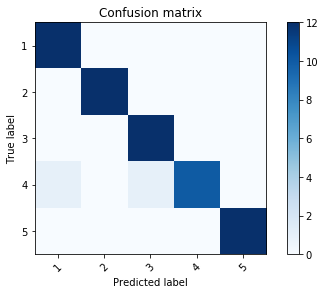

In [14]:
# After completing the code cell above, this should plot the confusion matrix.
cm = confusion_matrix(labels, predicted_labels)
plot_confusion_matrix(cm)